### Path Prediction

#### Import Libraries

In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import operator
import random
from copy import deepcopy

#### Implement Different Criterions

In [2]:
def get_cost_based_on_fuel(fuel, time):
    return -fuel

def get_cost_based_on_time(fuel, time):
    return -time

def get_cost_based_on_mixture(fuel, time):
    return fuel + time**2

#### MapBuilder

This class will make a graph based on input data and has different methods. "next_State" method will give next state. "get_Reward" method will give reward of each action from specific state. "initial_state" method will give initial state and "terminal_state" will give the goal state."plot_gragh" is a method for visulization.

In [3]:
class MapBuilder:

    def __init__(self):
        self.data_df = pd.read_csv('data.csv')
        number_of_edges = len(self.data_df)
        self.G = nx.DiGraph()

        for i in range(0, number_of_edges):
            start = self.data_df.iloc[i]['start']
            end = self.data_df.iloc[i]['end']
            Energy = self.data_df.iloc[i]['Energy']
            Time = self.data_df.iloc[i]['Time']

            self.G.add_edge(start, end, Energy=Energy, Time=Time)

    def next_State(self, state):
        edges = [n for n in self.G.neighbors(state)]
        return edges

    def get_Reward(self, start, end):
        edge = self.data_df.loc[(self.data_df['start'] == (start)) & (self.data_df['end'] == (end))]
        Energy = edge.iloc[0]['Energy']
        Time = edge.iloc[0]['Time']
        return [np.random.normal(Energy, 0.5), np.random.normal(Time, 0.5)]

    def initial_state(self):
        return 1

    def terminal_state(self):
        return 11
    
    def plot_graph(self, criterion, title):
        
        black_edges = [edge for edge in self.G.edges()]
        pos = nx.spring_layout(self.G)
        
        labels = {}
        if criterion == "Energy":
            labels = nx.get_edge_attributes(self.G,'Energy')
        if criterion == "Time":
            labels = nx.get_edge_attributes(self.G,'Time')
        if criterion == "Mixture":
            e = nx.get_edge_attributes(self.G,'Energy')
            t = nx.get_edge_attributes(self.G,'Time')
            for key in list(e.keys()):
                labels[key] = e[key] + t[key]**2
        nx.draw_networkx_nodes(self.G, pos, cmap=plt.get_cmap('jet'), 
                         node_size = 500)
        nx.draw_networkx_labels(self.G, pos)
        nx.draw_networkx_edges(self.G, pos, edgelist=black_edges, arrows=False)
        nx.draw_networkx_edge_labels(self.G,pos,edge_labels=labels)
        plt.title(title)
        plt.rcParams["figure.figsize"] = (10, 10)
        plt.show()

In [4]:
mapbuilder = MapBuilder()

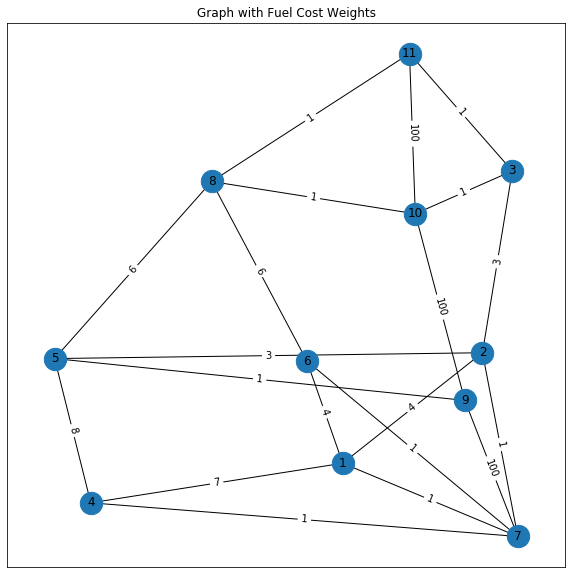

In [8]:
mapbuilder.plot_graph("Energy", "Graph with Fuel Cost Weights")

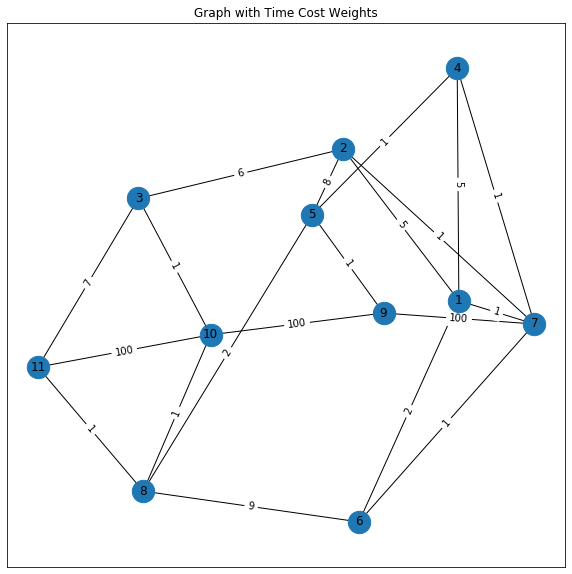

In [18]:
mapbuilder.plot_graph("Time", "Graph with Time Cost Weights")

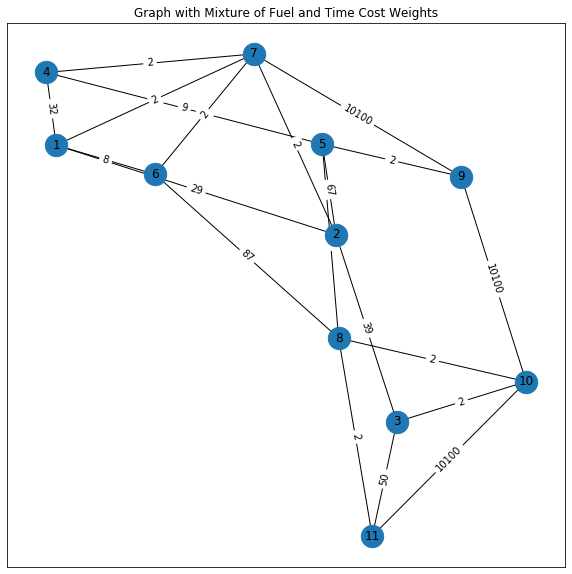

In [19]:
mapbuilder.plot_graph("Mixture", "Graph with Mixture of Fuel and Time Cost Weights")

#### QLearner

QLearner is a core class in training process. It will update Q_table and make a choice based on it.

In [9]:
class QLearner:
    def __init__(self, initial_state, criterion, move_request, terminal, alpha, gamma, next_state, decay=0.001):
        self._move_request = move_request
        self.criterion = criterion
        self._previous_state = None
        self._state = initial_state
        self._Q = {self._state: {}}
        self.alpha = alpha
        self.gamma = gamma
        self.next_state = next_state
        self._terminal = terminal
        self.decay = decay
        self.epsilon = 0.5

    def _get_max_action(self, state):
        try:
            return max(self._Q[state].items(), key=operator.itemgetter(1))[0]
        except Exception:
            self._Q[state] = {}
            next_states = self.next_state(self._state)
            if len(next_states) != 0:
                return random.choice(next_states)
            else:
                return self._terminal

    def _update(self, action, reward):
        if self._state not in self._Q:
            self._Q[self._state] = {}
        self._Q[self._previous_state][action] = (1.0 - self.alpha) * self._Q[self._previous_state].get(action, 0) + self.alpha * (reward + self.gamma * self._Q[self._state].get(self._get_max_action(self._state), 0))

    def move(self):
        self._previous_state = self._state
        if random.uniform(0, 1) > self.epsilon:
            action = self._get_max_action(self._state)
        else:
            next_states = self.next_state(self._state)
            if len(next_states) != 0:
                action = random.choice(next_states)
            else:
                action = self._terminal
        observation = self._move_request(self._state, action)
        self._state = observation.get('state', self._state)
        energy = observation.get('energy', 0)
        time = observation.get('time', 0)
        self._update(action, self.criterion(energy, time))
        self.alpha = max(0, self.alpha - self.decay)

    def reset(self, initial_state):
        self._state = initial_state
        self._previous_state = None

#### Universe

It is a class that connects user to background layers.

In [10]:
class Universe:
    def __init__(self, map_builder):
        self._map_builder = map_builder

    def next_state(self, state):
        return self._map_builder.next_State(state)
    
    def move_request(self, state, action):
        if action not in self._map_builder.next_State(state):
            raise Exception("Wrong action pal")

        next_state = action
        energy, time = self._map_builder.get_Reward(state, action)
        return {'state': next_state, 'energy': energy, 'time': time}

    def get_initial_state(self):
        return self._map_builder.initial_state()
    
    def get_terminal_state(self):
        return self._map_builder.terminal_state()

#### Main Part

In [11]:
universe = Universe(MapBuilder())
qlearners = [QLearner(universe.get_initial_state(), get_cost_based_on_fuel, universe.move_request, universe.get_terminal_state(), 1, 0.9, universe.next_state)
            , QLearner(universe.get_initial_state(), get_cost_based_on_time, universe.move_request, universe.get_terminal_state(), 1, 0.9,  universe.next_state)
            , QLearner(universe.get_initial_state(), get_cost_based_on_mixture, universe.move_request, universe.get_terminal_state(), 1, 0.9, universe.next_state)]


num_of_epochs = 1000

for epoch_num in range(num_of_epochs):
    for qlearner in qlearners:
        while qlearner._state != universe.get_terminal_state():
            qlearner.move()
        qlearner.reset(universe.get_initial_state())

#### Get Best Path Based on Fuel Cost

In [12]:
path = [1]
prev = None
curr = universe.get_initial_state()
while curr != universe.get_terminal_state():
    prev = curr
    curr = list(qlearners[0]._Q[prev].keys())[np.argmax(list(qlearners[0]._Q[prev].values()))]
    path.append(curr)

In [13]:
path

[1, 2, 3, 11]

#### Get Best Path Based on Time Cost

In [14]:
path = [1]
prev = None
curr = universe.get_initial_state()
while curr != universe.get_terminal_state():
    prev = curr
    curr = list(qlearners[1]._Q[prev].keys())[np.argmax(list(qlearners[1]._Q[prev].values()))]
    path.append(curr)

In [15]:
path

[1, 4, 5, 8, 11]

#### Get Best Path Based on Mixture of Fuel and Time Cost

In [16]:
path = [1]
prev = None
curr = universe.get_initial_state()
while curr != universe.get_terminal_state():
    prev = curr
    curr = list(qlearners[2]._Q[prev].keys())[np.argmax(list(qlearners[2]._Q[prev].values()))]
    path.append(curr)

In [17]:
path

[1, 7, 9, 10, 11]